## Necessary Imports

In [557]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#ARIMA modules
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

#Regression metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model

import pmdarima as pm
from pmdarima.model_selection import train_test_split

#datetime
from pandas import to_datetime

import itertools
import warnings

import datetime
from datetime import datetime
warnings.filterwarnings('ignore')

#Increases the size of sns plots
#sns.set(rc={'figure.figsize':(8,6)})


## Problem Formulation - What are we trying to solve?
We want to forecast **the GDP per Capita per country** for the next **7 to 10** years


In [558]:
data=pd.read_csv('gdp_raw_data.csv',encoding='latin-1')


In [559]:
dic={'SP_DYN_TFRT_IN':'demo_ind', 'Fertility rate, total (births per woman)':'indicator', 'AUS':'location',
       'Australia':'country', '1970':'time', '2.86':'value', 'Unnamed: 6':'flag codes', 'Unnamed: 7':'flags'}

In [560]:
data.rename(columns=dic,inplace=True)

In [561]:
data.head()

,demo_ind,indicator,location,country,time,value,flag codes,flags
0,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1971,2.96,NaN,NaN
1,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1972,2.74,NaN,NaN
2,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1973,2.49,NaN,NaN
3,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1974,2.40,NaN,NaN
4,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1975,2.15,NaN,NaN


In [446]:
print(data.shape)

(270037, 8)


In [562]:
data.describe()

,time,value
count,270037.000000,2.679710e+05
mean,1996.589641,4.894175e+12
std,13.408955,1.533647e+14
min,1970.000000,-6.405000e+01
25%,1986.000000,9.200000e+00
50%,1998.000000,5.607800e+02
75%,2008.000000,4.435194e+04
max,2019.000000,1.530000e+16


In [563]:
data.dtypes.value_counts()

object     6
float64    1
int64      1
dtype: int64

In [449]:
data.isna().sum().sort_values()

demo_ind           0
indicator          0
location           0
country            0
time               0
value           2066
flag codes    267971
flags         267971
dtype: int64

In [450]:
data['indicator'][data['value'].isnull()].unique()

array(['Population growth (annual %)',
       'Rural population (% of total population)',
       'GDP deflator (base year varies by country)',
       'GDP growth (annual %)',
       'Poverty headcount ratio at $1.90 a day (PPP) (% of population)',
       'PPP conversion factor, GDP (LCU per international $)',
       'Total debt service (% of GNI)', 'GNI per capita (current LCU)',
       'Official exchange rate (LCU per US$, period average)',
       'GDP per capita (current LCU)',
       'PPP conversion factor, private consumption (LCU per international $)',
       'DEC alternative conversion factor (LCU per US$)'], dtype=object)

In [451]:
#droping the null values
data['value'].isnull()

0         False
1         False
2         False
3         False
4         False
          ...  
270032    False
270033    False
270034    False
270035    False
270036    False
Name: value, Length: 270037, dtype: bool

In [452]:
data.dropna(subset=['value'],inplace=True)

In [453]:
data.shape

(267971, 8)

In [454]:
# dropping the last 2 columns useless
data.drop(axis=1,columns=['flag codes','flags'],inplace=True)


In [565]:
data.isna().sum()

demo_ind           0
indicator          0
location           0
country            0
time               0
value           2066
flag codes    267971
flags         267971
dtype: int64

In [569]:
tot_values=[]
for col in data:
    unique_vals=np.unique(data[col])
    nbr_values=len(unique_vals)
    tot_values.append(nbr_values)
    if nbr_values <= 50:
        print(f'the number of unique values for feature {col}:{nbr_values }-- {unique_vals}')
    else:
        print(f'the number of unique values for feature {col}:{nbr_values}')
print(tot_values)

the number of unique values for feature demo_ind:1-- ['NY_GDP_PCAP_PP_CD']
the number of unique values for feature indicator:1-- ['GDP per capita, PPP (current international $)']
the number of unique values for feature location:195
the number of unique values for feature country:195
the number of unique values for feature time:28-- [1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]
the number of unique values for feature value:5164
the number of unique values for feature flag codes:5176
the number of unique values for feature flags:5176
[1, 1, 195, 195, 28, 5164, 5176, 5176]


In [570]:
#filtering the data only get the gdp per capita
data=data[data['indicator']=='GDP per capita, PPP (current international $)']
print(data.shape)

(5176, 8)


In [571]:
data.head()

,demo_ind,indicator,location,country,time,value,flag codes,flags
76847,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1990,17333.10,NaN,NaN
76848,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1991,17793.60,NaN,NaN
76849,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1992,18189.34,NaN,NaN
76850,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1993,19130.89,NaN,NaN
76851,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1994,20063.81,NaN,NaN


In [469]:
data[data['location']=='GHA']

,demo_ind,indicator,location,country,time,value
78908,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",GHA,Ghana,1990,1240.41
78909,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",GHA,Ghana,1991,1312.49
78910,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",GHA,Ghana,1992,1356.22
78911,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",GHA,Ghana,1993,1416.22
78912,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",GHA,Ghana,1994,1454.40
78913,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",GHA,Ghana,1995,1506.11
78914,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",GHA,Ghana,1996,1564.50
78915,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",GHA,Ghana,1997,1618.20
78916,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",GHA,Ghana,1998,1672.04
78917,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",GHA,Ghana,1999,1730.02


In [572]:
#droping the rest of the columns we don't need
data=data[['country','time','value']]
print(data.shape)

(5176, 3)


In [573]:
#remove the column that have missing gdp values from 1990-2017
country_list=[country  for country in np.unique(data['country']) if (data[data['country']==country].shape[0]<28) ]
print(len(country_list),'\n',country_list)

32 
 ['Afghanistan', 'Bermuda', 'Bosnia and Herzegovina', 'Cambodia', 'Cayman Islands', 'Croatia', 'Curaçao', 'Djibouti', 'Eritrea', 'Estonia', 'Hungary', 'Kuwait', 'Latvia', 'Liberia', 'Libya', 'Lithuania', 'Maldives', 'Montenegro', 'Nauru', 'Palau', 'Palestine', 'Qatar', 'Republic of Moldova', 'San Marino', 'Sao Tome and Principe', 'Serbia', 'Sint Maarten (Dutch part)', 'Slovakia', 'Slovenia', 'South Sudan', 'Timor-Leste', 'Venezuela (Bolivarian Republic of)']


In [574]:
data['time'] = data['time'].astype(str) + '-01-01'
data['time'] = pd.to_datetime(data['time'])

In [575]:
data.set_index('time',inplace=True)

In [576]:
data.head()

,country,value
time,,
1990-01-01,Australia,17333.10
1991-01-01,Australia,17793.60
1992-01-01,Australia,18189.34
1993-01-01,Australia,19130.89
1994-01-01,Australia,20063.81


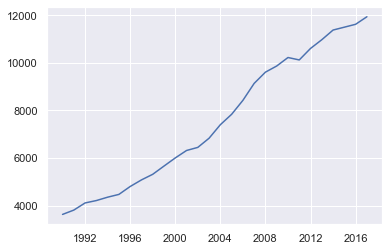

In [577]:
fig, ax=plt.subplots()
tn_data=data[data['country']=='Tunisia']
ax.plot(tn_data.index,tn_data['value'])

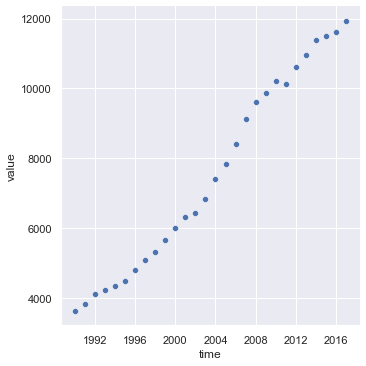

In [578]:
sns.relplot(x='time',y='value',data=tn_data,kind='scatter')

In [579]:
########################################################################################################
####################################### Running ARIMA on Tunisia #####################################
########################################################################################################

#filterin the training data
X_train=tn_data[tn_data.index<'2012-01-01']
X_test=tn_data[tn_data.index>='2011-01-01']
print(f'X_train shape {X_train.shape}')
print(f'X_test shape {X_test.shape}')

X_train shape (22, 2)
X_test shape (7, 2)


In [614]:
index_before2011=pd.date_range(start=X_train.index[0],end=X_train.index[-1],freq='AS')
index_before2011
#defining the period for which we want a prediction for the test-data
df_index_before2011=pd.DataFrame(index_before2011)
df_index_before2011.columns=['ds']
df_index_before2011    
    

,ds
0,1990-01-01
1,1991-01-01
2,1992-01-01
3,1993-01-01
4,1994-01-01
5,1995-01-01
6,1996-01-01
7,1997-01-01
8,1998-01-01
9,1999-01-01


In [615]:
index_all_years=pd.date_range(start=tn_data.index[0],end=tn_data.index[-1],freq='AS')
index_all_years
#define the period for which we want a prediction for the future
df_index_all_years=pd.DataFrame(index_all_years)
df_index_all_years.columns=['ds']
df_index_all_years

,ds
0,1990-01-01
1,1991-01-01
2,1992-01-01
3,1993-01-01
4,1994-01-01
5,1995-01-01
6,1996-01-01
7,1997-01-01
8,1998-01-01
9,1999-01-01


In [580]:
index_7years=pd.date_range(end=X_test.index[-1],freq='AS',periods=7)#freq='AS' to maintain the same frequency
index_7years

DatetimeIndex(['2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01',
               '2015-01-01', '2016-01-01', '2017-01-01'],
              dtype='datetime64[ns]', freq='AS-JAN')

In [581]:
#filtering the country column
X_train.drop('country',axis=1,inplace=True)

In [413]:
X_train

,value
time,
1990-01-01,3628.26
1991-01-01,3809.85
1992-01-01,4110.26
1993-01-01,4211.28
1994-01-01,4352.53
1995-01-01,4469.27
1996-01-01,4801.23
1997-01-01,5078.81
1998-01-01,5314.26


In [582]:
X_test.drop('country',axis=1,inplace=True)
X_test

,value
time,
2011-01-01,10120.68
2012-01-01,10603.76
2013-01-01,10971.23
2014-01-01,11377.35
2015-01-01,11497.79
2016-01-01,11618.80
2017-01-01,11936.23


The RMSE of ARIMA is: 1215.468569328392


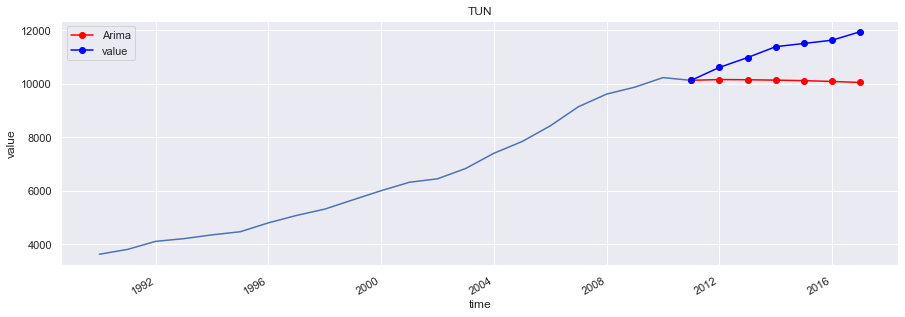

In [583]:
# Running ARIMA with random numbers
model_arima = ARIMA(X_train, order=(2,2,0)) # start 2-0-0 and move to the best
model_arima_fit = model_arima.fit(disp=-1)

# Saving ARIMA predictions
fcast1 = model_arima_fit.forecast(7)[0]

# Passing the same index as the others
fcast1 = pd.Series(fcast1, index=index_7years)
fcast1 = fcast1.rename("Arima") 

# Ploting the predictions
fig, ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot(x=X_train.index, y='value', data =X_train )
chart.set_title('TUN')
fcast1.plot(ax=ax, color='red', marker="o", legend=True)
X_test.plot(ax=ax, color='blue', marker="o", legend=True)

# Printing the AI
print('The RMSE of ARIMA is:', mean_squared_error(X_test['value'].values, fcast1.values, squared=False))

In [482]:
#Optimazing the model
import itertools
p=d=q=range(0,5)
pdq = list(itertools.product(p,d,q))#computes all possible combinations of (p,d,q)
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (0, 3, 4),
 (0, 4, 0),
 (0, 4, 1),
 (0, 4, 2),
 (0, 4, 3),
 (0, 4, 4),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 4),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 2, 4),
 (1, 3, 0),
 (1, 3, 1),
 (1, 3, 2),
 (1, 3, 3),
 (1, 3, 4),
 (1, 4, 0),
 (1, 4, 1),
 (1, 4, 2),
 (1, 4, 3),
 (1, 4, 4),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 0, 4),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 2, 4),
 (2, 3, 0),
 (2, 3, 1),
 (2, 3, 2),
 (2, 3, 3),
 (2, 3, 4),
 (2, 4, 0),
 (2, 4, 1),
 (2, 4, 2),
 (2, 4, 3),
 (2, 4, 4),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 0, 4),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3,

In [483]:
aic_dic={}
for order in pdq:
    try:
        model_arima = ARIMA(X_train,order=order)
        model_arima_fit = model_arima.fit()
        aic_dic[str(order)]=model_arima_fit.aic
        print(order,model_arima_fit.aic)
    except:
        continue
print(aic_dic)
# The Akaike information criterion (AIC) is an estimator of in-sample prediction error and thereby relative quality of
# statistical models for a given set of data

# It's like the mean squared error in Regression - The smaller the number, the better

(0, 0, 0) 404.4958527337716
(0, 0, 1) 381.1954764098257
(0, 1, 0) 282.16882487393957
(0, 1, 1) 280.05552209080616
(0, 1, 2) 281.6342108023175
(0, 1, 3) nan
(0, 1, 4) 278.2313504090557
(0, 2, 0) 267.7913612509409
(0, 2, 1) 268.7141498482357
(0, 2, 2) 268.4641624811594
(0, 2, 3) 267.03139782958215
(0, 2, 4) 268.1804224594256
(1, 0, 0) 331.5726482848837
(1, 1, 0) 278.79779964179977
(1, 1, 1) 280.72064153646807
(1, 1, 2) 281.0366537538143
(1, 2, 0) 268.79062770666235
(1, 2, 1) 270.68891668932804
(1, 2, 3) 268.7265035411809
(2, 0, 0) 301.3534679276927
(2, 1, 0) 280.7021837381068
(2, 2, 0) 270.4711807155186
(2, 2, 1) 272.4338384213962
(3, 0, 0) 302.2300623905894
(3, 0, 1) 303.8267645120242
(3, 0, 2) 305.3725360803211
(3, 0, 4) 312.9029817921857
(3, 1, 0) 282.700131427209
(3, 2, 0) 271.0962486656475
(3, 2, 1) 273.0108665972112
(4, 0, 3) 303.80220769476176
(4, 1, 0) 281.59506445478416
(4, 2, 0) 272.7991601167827
(4, 2, 1) 274.4654935146908
{'(0, 0, 0)': 404.4958527337716, '(0, 0, 1)': 381.1954

In [484]:
#we get the combination with the minimum aic score
min(aic_dic,key=aic_dic.get)

'(0, 2, 3)'

<AxesSubplot:title={'center':'TUN'}, xlabel='time', ylabel='value'>

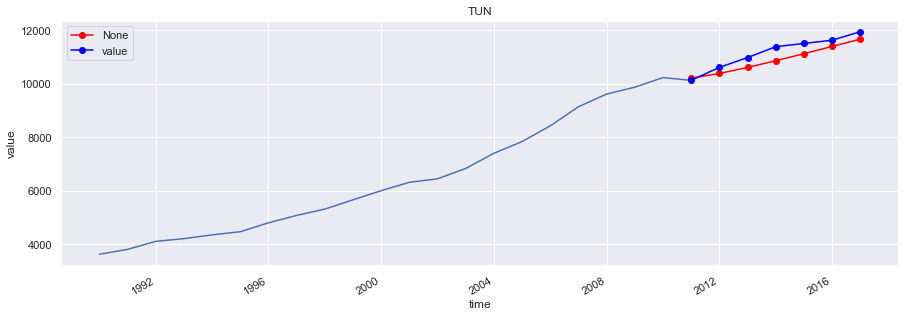

In [485]:
#2nd option: we use the auto-Arima model
auto_arima_model=pm.auto_arima(X_train,seasonal=False,m=7)


#forecasting
fcast2=auto_arima_model.predict(7)
fcast2=pd.Series(fcast2,index=index_7years)
fcast2.rename("Auto Arima")

#plotting the predictions
fig, ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot(x=X_train.index, y='value', data =X_train )
chart.set_title('TUN')
fcast2.plot(ax=ax, color='red', marker="o", legend=True)
X_test.plot(ax=ax, color='blue', marker="o", legend=True)


In [486]:
print('The RMSE of auto-arima is:', mean_squared_error(X_test['value'].values, fcast2.values, squared=False))

The RMSE of auto-arima is: 326.7659122785518


### Conclusion:
we have to run both models first the arima model and manually change the order parameter then the auto-arima model and chnage the m parameter which relates to the number of observations per seasonal cycle

## Running Prophet

- Prophet is open source software released by Facebook’s Core Data Science team

- Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality

- It works best with time series that have strong seasonal effects and several seasons of historical data. 

- Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.


In [487]:
from fbprophet import Prophet
#preparing the dataset for the Prohet model
#we have to set the time column values to Datetime values (already done)
tn2_data=data[data['country']=='Tunisia']
tn2_data=tn2_data[['value']]
tn2_data.reset_index(inplace=True)
tn2_data.columns=['ds','y']#the Prophet model only accepts these column names
tn2_data

,ds,y
0,1990-01-01,3628.26
1,1991-01-01,3809.85
2,1992-01-01,4110.26
3,1993-01-01,4211.28
4,1994-01-01,4352.53
5,1995-01-01,4469.27
6,1996-01-01,4801.23
7,1997-01-01,5078.81
8,1998-01-01,5314.26
9,1999-01-01,5660.09


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.


The RMSE of prophet is: 132.48119474748867


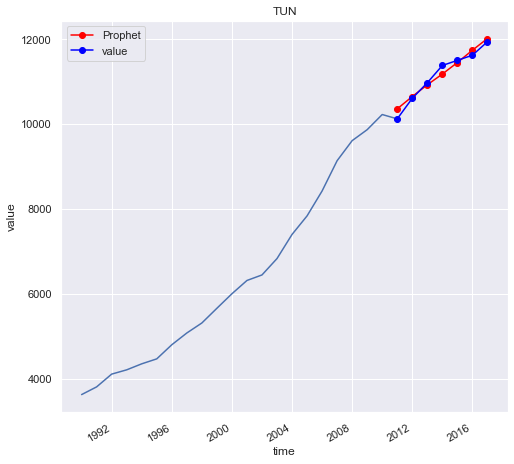

In [488]:
#defining the model
pr_model=Prophet()
#fitting the model
pr_model.fit(tn2_data)

#defining the period for which we want a prediction
df_index_7years=pd.DataFrame(index_7years)
df_index_7years.columns=['ds']


#forecasting
fcast3=pr_model.predict(df_index_7years)
fcast3=pd.Series(fcast3['yhat'].values,index=index_7years)
fcast3=fcast3.rename('Prophet')

#plotting the prediction
fig, ax =plt.subplots(figsize=(8,8))
chart=sns.lineplot(x=X_train.index,y='value',data=X_train)
chart.set_title('TUN')
fcast3.plot(ax=ax,color='red',marker='o',legend=True)
X_test.plot(ax=ax,color='blue',marker='o',legend=True)

# Printing the AI
print('The RMSE of prophet is:', mean_squared_error(X_test['value'].values, fcast3.values, squared=False))

In [489]:
pr_model.predict(df_index_7years)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-01,7818.823398,10242.281691,10478.424920,7818.823398,7818.823398,2537.990479,2537.990479,2537.990479,2537.990479,2537.990479,2537.990479,0.0,0.0,0.0,10356.813877
1,2012-01-01,8091.058115,10529.267996,10763.453495,8091.058115,8091.058115,2555.321571,2555.321571,2555.321571,2555.321571,2555.321571,2555.321571,0.0,0.0,0.0,10646.379686
2,2013-01-01,8364.038680,10808.261886,11034.777225,8364.038680,8364.038680,2558.916609,2558.916609,2558.916609,2558.916609,2558.916609,2558.916609,0.0,0.0,0.0,10922.955289
3,2014-01-01,8636.273397,11062.196434,11286.765680,8636.273397,8636.273397,2539.253566,2539.253566,2539.253566,2539.253566,2539.253566,2539.253566,0.0,0.0,0.0,11175.526963
4,2015-01-01,8908.508114,11326.846055,11565.584492,8908.508114,8908.508114,2537.990479,2537.990479,2537.990479,2537.990479,2537.990479,2537.990479,0.0,0.0,0.0,11446.498593
5,2016-01-01,9180.742831,11617.779780,11855.018493,9180.742831,9180.742831,2555.321571,2555.321571,2555.321571,2555.321571,2555.321571,2555.321571,0.0,0.0,0.0,11736.064402
6,2017-01-01,9453.723396,11903.227153,12124.633533,9453.723396,9453.723396,2558.916609,2558.916609,2558.916609,2558.916609,2558.916609,2558.916609,0.0,0.0,0.0,12012.640005


### Running all Time Series Model together

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.


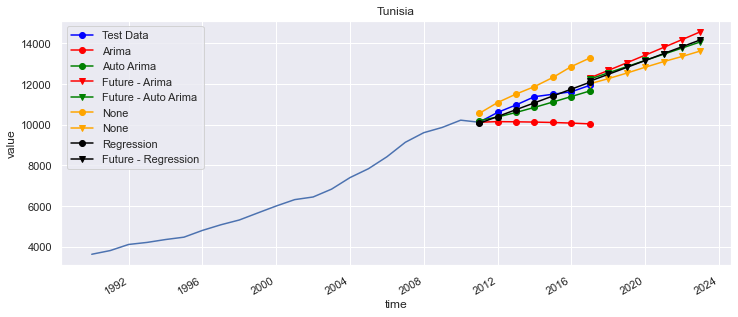

In [631]:
#First let's start with Arima and Auto-Arima
#countries_list=data['country'].unique()
countries_list=['Tunisia']

for country in countries_list:
    #training data
    country_data=data[data['country']==country]
    train_data=country_data[country_data.index<'2012-01-01']
    train_data=train_data.drop('country',axis=1)
    
    #testing data
    test_data=country_data[country_data.index>='2011-01-01']
    test_data=test_data.drop('country',axis=1)
    
    #the entire data
    all_data=country_data
    all_data=all_data.drop('country',axis=1)
    
    #already set the index to dateTime
    test_data.columns=['Test Data']
    
    #setting the index for 7 years
    #index_7years variable already done
    
    #setting the future index for 7 years
    future_index_7years=pd.date_range(test_data.index[-1],freq='AS',periods=7)
    
    
     # Dropping all tables
    try:
        del t_fcast1
        del t_fcast2
        #del t_fcast3
        
        del f_fcast1
        del f_fcast2
        #del f_fcast3       
        
    except:
        print("")

    try:
        del df_fcast1
        del df_fcast2
        del df_fcast3
    except:
        print("")
        
    ##############################################################################################################
    ######################################            ARIMA             ##########################################  
    ##############################################################################################################
    
    #This is for the testing phase
    try:        
        try:
            # Running ARIMA on Best parameter
            model_arima = ARIMA(train_data, order=(2,2,0))
            model_arima_fit = model_arima.fit(disp=-1)

            # Saving ARIMA predictions
            t_fcast1 = model_arima_fit.forecast(7)[0]
            # Passing the same index as the others
            t_fcast1 = pd.Series(t_fcast1, index=index_7years)
            t_fcast1 = t_fcast1.rename("Arima") 
        except:
            # Running ARIMA on 2nd Best parameter
            model_arima = ARIMA(train_data, order=(0,2,3))
            model_arima_fit = model_arima.fit(disp=-1)

            # Saving ARIMA predictions
            t_fcast1 = model_arima_fit.forecast(7)[0]
            # Passing the same index as the others
            t_fcast1 = pd.Series(t_fcast1, index=index_7years)
            t_fcast1 = t_fcast1.rename("Arima") 
    except:
        print(c, "Arima Train Error")
        
     # THIS IS FOR THE FUTURE PHASE
    try:        
        try:
            # Running ARIMA on Best parameter
            model_arima = ARIMA(all_data, order=(0,2,2))
            model_arima_fit = model_arima.fit(disp=-1)

            # Saving ARIMA predictions
            f_fcast1 = model_arima_fit.forecast(7)[0]
            # Passing the same index as the others
            f_fcast1 = pd.Series(f_fcast1, index=future_index_7years)
            f_fcast1 = f_fcast1.rename("Future - Arima") 
        except:
            # Running ARIMA on 2nd Best parameter
            model_arima = ARIMA(all_data, order=(0,2,3))
            model_arima_fit = model_arima.fit(disp=-1)

            # Saving ARIMA predictions
            f_fcast1 = model_arima_fit.forecast(7)[0]
            # Passing the same index as the others
            f_fcast1 = pd.Series(f_fcast1, index=future_index_7years)
            f_fcast1 = f_fcast1.rename("Future - Arima") 
    except:
        print(c, "Arima Future Error")  
    
     ##############################################################################################################
    ######################################      AUTO - ARIMA             ######################################### 
    ##############################################################################################################
    
    try:
        # Running auto ARIMA 
        auto_arima_model = pm.auto_arima(train_data, seasonal=False, m=7)

        # make your forecasts
        t_fcast2 = auto_arima_model.predict(7) 
        t_fcast2 = pd.Series(t_fcast2, index=index_7years)
        t_fcast2 = t_fcast2.rename("Auto Arima")

    except:
        print(c, "Auto Arima Train Error") 
        
     # THIS IS FOR THE FUTURE PHASE
    try:
        # Running auto ARIMA Future
        auto_arima_model = pm.auto_arima(all_data, seasonal=False, m=7)

        # make your forecasts
        f_fcast2 = auto_arima_model.predict(7) 
        f_fcast2 = pd.Series(f_fcast2, index=future_index_7years)
        f_fcast2 = f_fcast2.rename("Future - Auto Arima")

    except:
        print(c, "Auto Arima Future Error")  
        
     ##############################################################################################################
    ######################################      PROPHET             ############################################## 
    ##############################################################################################################
    #prepare the data
    pr_train_data=country_data[country_data['country']==country]
    pr_train_data=pr_train_data[pr_train_data.index<'2012-01-01']
    pr_train_data=pr_train_data[['value']]
    pr_train_data.reset_index(inplace=True)
    pr_train_data.columns=['ds','y']
    
    pr_all_data=all_data
    pr_all_data.reset_index(inplace=True)
    pr_all_data.columns=['ds','y']
    
    
    #defining the period for which we want a prediction for the test-data
    df_index_7years=pd.DataFrame(index_7years)
    df_index_7years.columns=['ds']
    
    #define the period for which we want a prediction for the future
    f_df_index_7years=pd.DataFrame(future_index_7years)
    f_df_index_7years.columns=['ds']
    
    ##################### testing phase ##################### 
    #define the model
    t_pr_model=Prophet()
    #fitting the model
    t_pr_model.fit(pr_train_data)
    #forecasting
    t_fcast3=t_pr_model.predict(df_index_7years)
    t_fcast3=pd.Series(t_fcast3['yhat'].values,index=index_7years)
    t_fcast3.rename("Prophet")
    
    ###################### future phase ########################
     #define the model
    f_pr_model=Prophet()
    #fitting the model
    f_pr_model.fit(pr_all_data)
    #forecasting
    f_fcast3=f_pr_model.predict(f_df_index_7years)
    f_fcast3=pd.Series(f_fcast3['yhat'].values,index=future_index_7years)
    f_fcast3.rename("Prophet")
    
    
    ##############################################################################################################
    ########################################      Regression              ##########################################
    ##############################################################################################################
    
    #Creating Ordinal Dates 
    train_data['MonthNumberOrdinal']=df_index_before2011['ds'].map(datetime.toordinal)
    #print(type(train_data['MonthNumberOrdinal'].values[0]))
    #train_data['MonthNumberOrdinal']=train_data['MonthNumberOrdinal'].map(datetime.toordinal)
    
    
    
    all_data['MonthNumberOrdinal']=df_index_all_years['ds'].map(datetime.toordinal)
    #all_data['MonthNumberOrdinal']=all_data['MonthNumberOrdinal'].map(datetime.toordinal)
    
    #adding the ordinal dates to the prediction dates
    df_index_7years['forecastDate_ordinal']=df_index_7years['ds'].map(datetime.toordinal)
    f_df_index_7years['forecastDate_ordinal']=f_df_index_7years['ds'].map(datetime.toordinal)
    
    #fitting linear reg on the train_data
    reg_model=linear_model.LinearRegression()
    reg_model.fit(df_index_before2011['ds'].map(datetime.toordinal).values.reshape(-1,1),train_data['value'].values)
    
    # Making predictions
    t_fcast4 = reg_model.predict(df_index_7years['forecastDate_ordinal'].values.reshape(-1, 1))
    
    # Passing the same index as the others
    t_fcast4 = pd.Series(t_fcast4, index=index_7years)
    t_fcast4 = t_fcast4.rename("Regression")

    # Fitting Linear reg on Future
    f_reg_model = linear_model.LinearRegression()
    f_reg_model.fit(all_data['MonthNumberOrdinal'].values.reshape(-1, 1), all_data['y'].values)

    # Making predictions
    f_fcast4 = f_reg_model.predict(f_df_index_7years['forecastDate_ordinal'].values.reshape(-1, 1))

    # Passing the same index as the others
    f_fcast4 = pd.Series(f_fcast4, index=future_index_7years)
    f_fcast4 = f_fcast4.rename("Future - Regression")

    
    
    
    
    ##############################################################################################################
    ########################################      PLOTTING              ##########################################
    ##############################################################################################################
    
    fig, ax = plt.subplots(figsize=(12,5))
    chart = sns.lineplot(x=train_data.index, y='value', data = train_data)
    chart.set_title(country)
    test_data.plot(ax=ax, color='blue', marker="o", legend=True)
    # ploting validation
    try:
        t_fcast1.plot(ax=ax, color='red', marker="o", legend=True)
    except:
        print("")        
    try:
        t_fcast2.plot(ax=ax, color='green', marker="o", legend=True)
    except:
        print("")
        
    # plotting future
    try:
        f_fcast1.plot(ax=ax, color='red', marker="v", legend=True)
    except:
        print("")        
    try:
        f_fcast2.plot(ax=ax, color='green', marker="v", legend=True)
    except:
        print("")  
        
    t_fcast3.plot(ax=ax, color='orange', marker="o", legend=True)
    f_fcast3.plot(ax=ax, color='orange', marker="v", legend=True)
    
    t_fcast4.plot(ax=ax, color='black', marker="o", legend=True)
    f_fcast4.plot(ax=ax, color='black', marker="v", legend=True) 
    
    
   

In [633]:
f_df_index_7years

,ds,forecastDate_ordinal
0,2017-01-01,736330
1,2018-01-01,736695
2,2019-01-01,737060
3,2020-01-01,737425
4,2021-01-01,737791
5,2022-01-01,738156
6,2023-01-01,738521


In [621]:
df_index_all_years

,ds
0,1990-01-01
1,1991-01-01
2,1992-01-01
3,1993-01-01
4,1994-01-01
5,1995-01-01
6,1996-01-01
7,1997-01-01
8,1998-01-01
9,1999-01-01


In [622]:
df_index_before2011

,ds
0,1990-01-01
1,1991-01-01
2,1992-01-01
3,1993-01-01
4,1994-01-01
5,1995-01-01
6,1996-01-01
7,1997-01-01
8,1998-01-01
9,1999-01-01


In [596]:
test_data

,Test Data
time,
2011-01-01,10120.68
2012-01-01,10603.76
2013-01-01,10971.23
2014-01-01,11377.35
2015-01-01,11497.79
2016-01-01,11618.80
2017-01-01,11936.23


In [607]:
df_index_7years

,ds,forecastDate_ordinal
0,2011-01-01,734138
1,2012-01-01,734503
2,2013-01-01,734869
3,2014-01-01,735234
4,2015-01-01,735599
5,2016-01-01,735964
6,2017-01-01,736330


In [594]:
country_data

,country,value
time,,
1990-01-01,Tunisia,3628.26
1991-01-01,Tunisia,3809.85
1992-01-01,Tunisia,4110.26
1993-01-01,Tunisia,4211.28
1994-01-01,Tunisia,4352.53
1995-01-01,Tunisia,4469.27
1996-01-01,Tunisia,4801.23
1997-01-01,Tunisia,5078.81
1998-01-01,Tunisia,5314.26


In [637]:
print(type(df_index_before2011['ds'].map(datetime.toordinal).values[0]))

<class 'numpy.int64'>


In [624]:
all_data

,ds,y,MonthNumberOrdinal
0,1990-01-01,3628.26,726468
1,1991-01-01,3809.85,726833
2,1992-01-01,4110.26,727198
3,1993-01-01,4211.28,727564
4,1994-01-01,4352.53,727929
5,1995-01-01,4469.27,728294
6,1996-01-01,4801.23,728659
7,1997-01-01,5078.81,729025
8,1998-01-01,5314.26,729390
9,1999-01-01,5660.09,729755


In [625]:
f_df_index_7years

,ds,forecastDate_ordinal
0,2017-01-01,736330
1,2018-01-01,736695
2,2019-01-01,737060
3,2020-01-01,737425
4,2021-01-01,737791
5,2022-01-01,738156
6,2023-01-01,738521


In [620]:
all_data

,ds,y,MonthNumberOrdinal
0,1990-01-01,3628.26,726468
1,1991-01-01,3809.85,726833
2,1992-01-01,4110.26,727198
3,1993-01-01,4211.28,727564
4,1994-01-01,4352.53,727929
5,1995-01-01,4469.27,728294
6,1996-01-01,4801.23,728659
7,1997-01-01,5078.81,729025
8,1998-01-01,5314.26,729390
9,1999-01-01,5660.09,729755


In [630]:
df_index_before2011['ds']

0    1990-01-01
1    1991-01-01
2    1992-01-01
3    1993-01-01
4    1994-01-01
5    1995-01-01
6    1996-01-01
7    1997-01-01
8    1998-01-01
9    1999-01-01
10   2000-01-01
11   2001-01-01
12   2002-01-01
13   2003-01-01
14   2004-01-01
15   2005-01-01
16   2006-01-01
17   2007-01-01
18   2008-01-01
19   2009-01-01
20   2010-01-01
21   2011-01-01
Name: ds, dtype: datetime64[ns]